<a href="https://colab.research.google.com/github/TytanMikJas/DeepLearningJourney/blob/main/ANN_Wine_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My own notebook and deep learning model for classifying wine quality score.
With help of Mike X Cohen to get the data :)

In [44]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats


# for dataset management
import pandas as pd

# for timing computations
import time

# for data visualization
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
display.set_matplotlib_formats('svg')

<ipython-input-44-3c74c00bc8aa>:25: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [45]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

<ipython-input-45-6f5cb70bcde3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>5] = 1


In [46]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

In [47]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

In [48]:
class ANNWineModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(11, 16)

        self.hidden1 = nn.Linear(16,32)

        self.hidden2 = nn.Linear(32,32)

        self.output = nn.Linear(32,1)


    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.output(x)
        return x

In [49]:
def create_model():
    ANNModel = ANNWineModel()

    loss = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.SGD(ANNModel.parameters(), lr=.01)

    return ANNModel, loss, optimizer

In [50]:
numepochs = 1000

def train_model(train_loader, test_loader):
    train_acc = []
    test_acc = []
    losses = []

    for i in range(numepochs):
        batch_acc = []
        batch_loss = []

        for X, y in train_loader:
            yHat = ANNModel(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_acc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
            batch_loss.append( loss.item() )

        train_acc.append( np.mean(batch_acc) )
        losses.append( np.mean(batch_loss) )


        X,y = next(iter(test_loader))
        predlabels =  ANNModel(X)
        test_acc.append( 100*torch.mean(((predlabels>0) == y).float()).item() )


    return train_acc, test_acc, losses

In [51]:
all_train_acc = []
all_test_acc = []
all_losses = []
all_times = []
batchsizes = 2**np.arange(1,10,2)
test_loader  = DataLoader(test_dataDataset, batch_size=test_dataDataset.tensors[0].shape[0])

for bi in batchsizes:

    train_loader = DataLoader(train_dataDataset, batch_size=int(bi), shuffle=True, drop_last=True)

    ANNModel, lossfun, optimizer = create_model()

    t_start = time.perf_counter()
    trainAcc, testAcc, losses = train_model(train_loader, test_loader)
    t_stop = time.perf_counter()

    all_train_acc.append(trainAcc)
    all_test_acc.append(testAcc)
    all_losses.append(losses)
    all_times.append(t_stop - t_start)

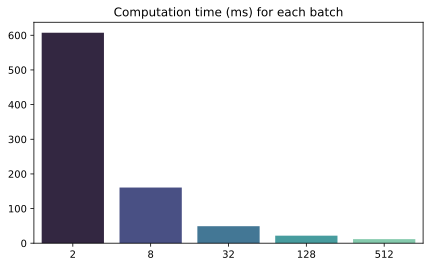

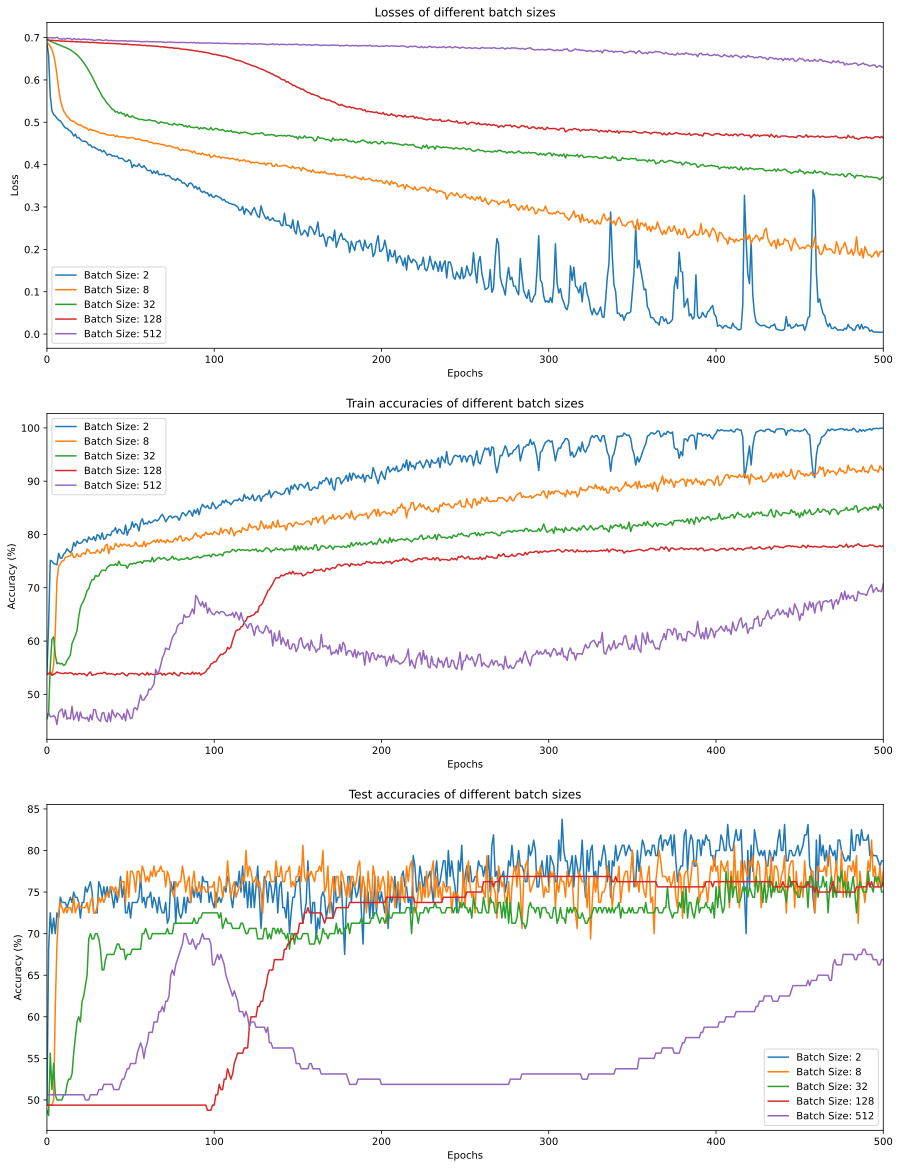

In [52]:

# Plot the results for times
plt.figure(figsize=(7, 4))
sns.barplot(x=batchsizes, y=all_times, palette='mako')
plt.title("Computation time (ms) for each batch")

plt.show()

# Plot the results for all batch sizes
fig, ax = plt.subplots(3, 1, figsize=(15, 20))

for i in range(len(batchsizes)):
    trainAcc = all_train_acc[i]
    testAcc = all_test_acc[i]
    losses = all_losses[i]

    # Plot losses
    ax[0].plot(losses, label=f'Batch Size: {batchsizes[i]}')

    # Plot train accuracies
    ax[1].plot(trainAcc, label=f'Batch Size: {batchsizes[i]}')

    # Plot test accuracies
    ax[2].plot(testAcc, label=f'Batch Size: {batchsizes[i]}')

# Set labels and titles
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses of different batch sizes')
ax[0].legend()
ax[0].set_xlim([0,500])

ax[1].set_title('Train accuracies of different batch sizes')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend()
ax[1].set_xlim([0,500])

ax[2].set_title('Test accuracies of different batch sizes')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Accuracy (%)')
ax[2].legend()
ax[2].set_xlim([0,500])

plt.show()